# Testing bias metrics and mitigation algorithms on the German Credit dataset

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from aif360.datasets import GermanDataset
from utility import *
sns.set_theme(style='darkgrid')

## Dataset description

This dataset classifies people described by a set of attributes as good or bad credit risks. The dataset consists of 1000 instances and 20 features. `age` and `sex` are the sensitive attributes. The dataset is bias w.r.t. women with age < 25.

## Dataset fairness metrics definition

The group fairness metrics related to the dataset are defined as follows:

- **Disparate impact**

$$
\frac{Pr(Y=1|S=unprivileged)}{Pr(Y=1|S=privileged)}
$$

> If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data

- **Statistical parity**

$$
Pr(Y=1|S=unprivileged)-Pr(Y=1|S=privileged)
$$

## Classifier fairness metrics definition

The group fairness metrics related to the classifier are defined below:

- **Balanced Accuracy**

$$
\frac{TP + TN}{2}
$$

- **Statistical parity**

$$
Pr(\hat{Y}=1|S=unprivileged)-Pr(\hat{Y}=1|S=privileged)
$$

- **Disparate Impact**

$$
\frac{Pr(\hat{Y}=1|S=unprivileged)}{Pr(\hat{Y}=1|S=privileged)}
$$

>If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data
- **Average odds difference**

$$
\frac{[(FPR_{S=unpriv} - FPR_{S=priv})+(TPR_{S=unpriv} - TPR_{S=priv})]}{2}
$$
>A value of 0 means _equality of odds_

- **Equal opportunity difference**

$$
TPR_{S=unpriv} - TPR_{S=priv}
$$

- **Theil Index**

$$
\frac{1}{n}\sum_{i=1}^n\frac{b_{i}}{\mu}\ln(\frac{b_{i}}{\mu}) \\
\text{with: } b_i=\hat{y_i}-y_i+1 \text{ and $\mu$ is the mean of $b_i$ }
$$
>Individual index measuring the distance of each individual predicted y from his real value. A value of 0 means equality. 

## Bias mitigation algorithms

In the following we will test two preprocessing bias mitigation algorithms and we will compare the impact they have on the model accuracy. The algorithms that we will test are the following:

1. **Reweighing**
    
> Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification

2. **Disparate Impact Remover**

> This algorithm changes the values of the unsensitive variables at different levels of repair. An higher level of repair removes the disparate impact but loweres the accuracy, while a low level of repair does not change the data. The values of the unsensitive attributes are changed s.t. the correlation between the variables and the sensitive attribute _S_ is removed while keeping the ranking of the items for the classifier. In this way it is no more possible to predict the sensitive variable _S_ from the unsensitive attributes.
>
> Following the pre processing procedure suggested by M. Feldman et al. in _"Certifying and removing disparate impact." ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 2015_, we first scale the values s.t. the minimum is 0 and the maximum is 1 and then remove the sensitive variable from the dataset before training the classifier.
>
>**NB:** Categorical data must be transformed in ordered values

3. **Sampling**

> Sampling is a modified version of the Reweighing algorithm. First of all, it considered the groups made by each combinantion of the values of sensitive variables and labels. Then, for each group it computes his disparity ($\frac{size\_exp}{size\_obs}$) and samples each group untill this value becomes 1. The final dataset will be a dataset in which each group is balanced.

# Importing and exploring the dataset

In [20]:
german = GermanDataset()
german.labels[german.labels == 2] = 0
german.unfavorable_label = 0

In [21]:
df = german.convert_to_dataframe()[0]
df

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,sex,status=A11,status=A12,...,housing=A153,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,credit
0,6.0,1169.0,4.0,4.0,1.0,2.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
1,48.0,5951.0,2.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,12.0,2096.0,2.0,3.0,1.0,1.0,2.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,42.0,7882.0,2.0,4.0,1.0,1.0,2.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,24.0,4870.0,3.0,4.0,1.0,2.0,2.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12.0,1736.0,3.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
996,30.0,3857.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
997,12.0,804.0,4.0,4.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
998,45.0,1845.0,4.0,4.0,0.0,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


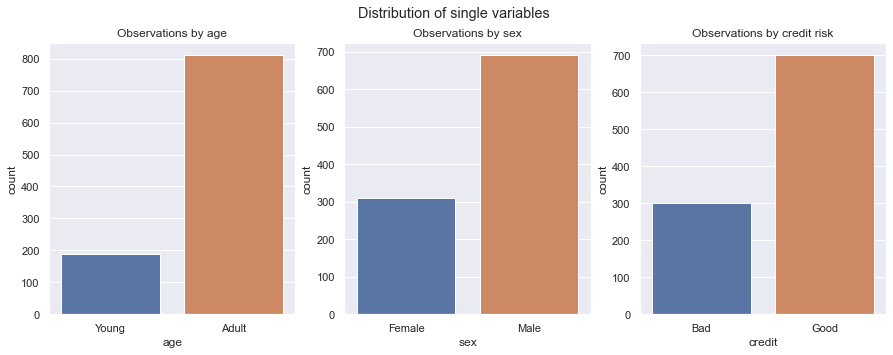

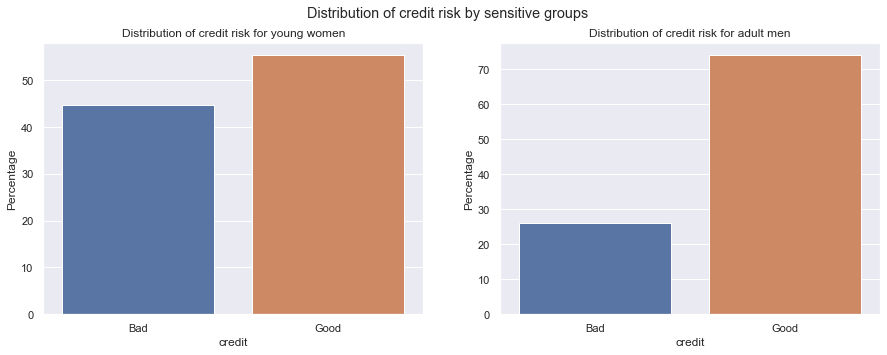

In [22]:
fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15,5))
sns.countplot(x='age', data=df, ax=ax1)
ax1.set_xticklabels(['Young','Adult'])
ax1.set_title('Observations by age')
sns.countplot(x='sex', data=df, ax=ax2)
ax2.set_xticklabels(['Female', 'Male'])
ax2.set_title('Observations by sex')
sns.countplot(x='credit', data=df, ax=ax3)
ax3.set_xticklabels(['Bad', 'Good'])
ax3.set_title('Observations by credit risk')
perc = (df[['sex','age','credit']]
        .groupby(['sex','age'])['credit']
        .value_counts(normalize=True)
        .mul(100).rename('Percentage')
        .reset_index()
       )
fig.suptitle("Distribution of single variables")
fig, [ax4, ax5] = plt.subplots(1,2, figsize=(15,5))
sns.barplot(data=perc[(perc['sex']==0)&(perc['age']==0)], x='credit', y='Percentage', ax=ax4)
ax4.set_xticklabels(['Bad', 'Good'])
ax4.set_title('Distribution of credit risk for young women')
sns.barplot(data=perc[(perc['sex']==1)&(perc['age']==1)], x='credit', y='Percentage', ax=ax5)
ax5.set_xticklabels(['Bad', 'Good'])
ax5.set_title('Distribution of credit risk for adult men')
fig.suptitle("Distribution of credit risk by sensitive groups")
plt.show()

In [23]:
priv_group = [{'age':1, 'sex':1}]
unpriv_group = [{'age':0, 'sex':0}]

# Bias dataset case

In [24]:
metrics = compute_dataset_fairness_metrics(german, unpriv_group=unpriv_group, priv_group=priv_group)

Disparate Impact = 0.7476
Statistical Parity = -0.1865


Balanced accuracy: 0.7073
Statistical parity difference: -0.2771
Disparate impact: 0.5820
Average odds difference: -0.1939
Equal opportunity difference: -0.1916
Theil index: 0.2599


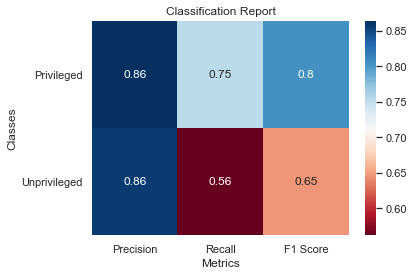

In [25]:
bias_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    german, priv_group, unpriv_group)

# Reweighing

In [26]:
rw_data = german.copy()
rw = Reweighing(unpriv_group, priv_group)
rw_data = rw.fit_transform(rw_data)

[0.67021277 0.94742729 1.         1.14873418 1.26724138]


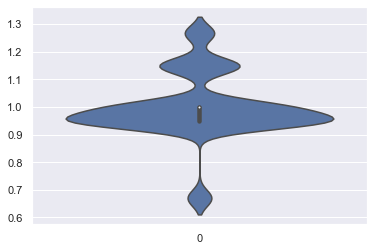

In [29]:
print(np.unique(rw_data.instance_weights))
sns.violinplot(data=rw_data.instance_weights)
plt.show()

In [30]:
metrics = compute_dataset_fairness_metrics(rw_data, unpriv_group, priv_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


Balanced accuracy: 0.6941
Statistical parity difference: -0.0597
Disparate impact: 0.9278
Average odds difference: -0.0386
Equal opportunity difference: -0.0321
Theil index: 0.2650


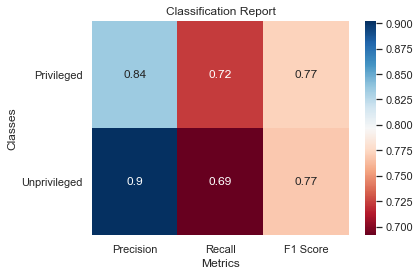

In [31]:
rw_class = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    rw_data, priv_group, unpriv_group)

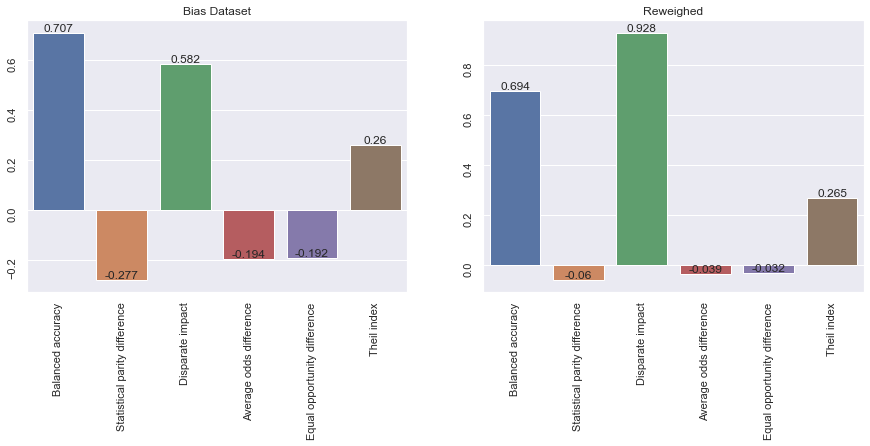

In [32]:
plot_metrics_comparison(bias_class, rw_class, 'Bias Dataset', 'Reweighed')
plt.show()

# Modified Reweighing (Sampling)

Original dataset size: (1000,59)
Sampled dataset size: (1009,59)


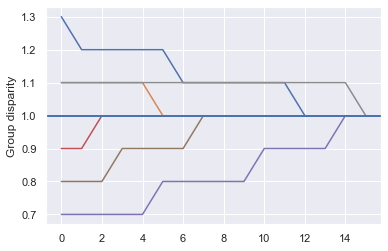

In [40]:
sampled_data = sample_dataset(
    df,
    [(df['sex']==0)&(df['age']==0), (df['sex']==1)&(df['age']==0), (df['sex']==0)&(df['age']==1), (df['sex']==1)&(df['age']==1)],
    df['credit']==1,
    df['credit']==0,
    ['sex', 'age'],
    'credit', round_level=1)

In [41]:
metrics = compute_dataset_fairness_metrics(sampled_data, unpriv_group, priv_group)

Disparate Impact = 0.9438
Statistical Parity = -0.0405


Balanced accuracy: 0.7006
Statistical parity difference: -0.0819
Disparate impact: 0.8822
Average odds difference: -0.0452
Equal opportunity difference: -0.0796
Theil index: 0.2635


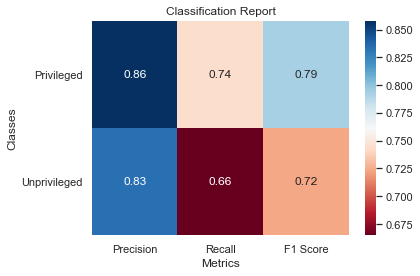

In [53]:
sampled_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    sampled_data, priv_group, unpriv_group)

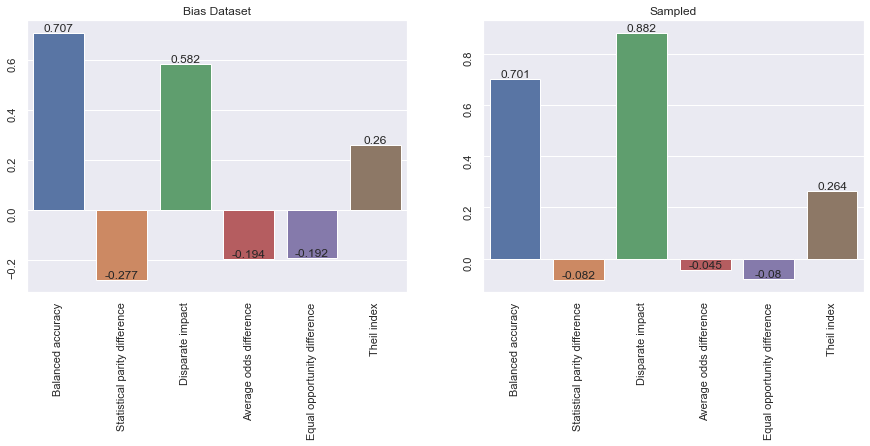

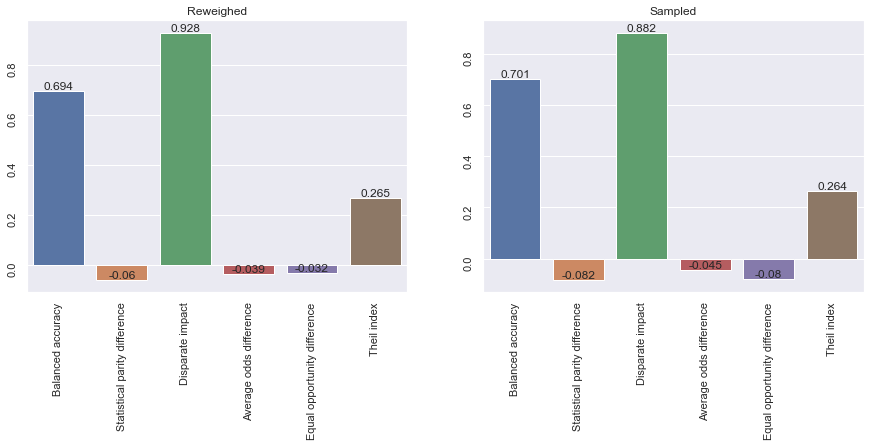

In [54]:
plot_metrics_comparison(bias_class, sampled_class, 'Bias Dataset', 'Sampled')
plot_metrics_comparison(rw_class, sampled_class, 'Reweighed', 'Sampled')
plt.show()

# Disparate Impact Remover

In [56]:
dir_data = german.copy()
scaler = MinMaxScaler(copy=False)
dir_data.features = scaler.fit_transform(dir_data.features)
df = dir_data.convert_to_dataframe()[0]

In [61]:
probs = (
    df.value_counts(["sex", "age"], normalize=True).unstack().reset_index()
    .melt(id_vars='sex', value_vars=[0.0,1.0], var_name='age', value_name='probs'))

for sex,age,prob in probs.values:
    df.loc[(df['sex'] == sex) & (df['age'] == age), 'prob'] = prob

df.drop(df[['sex','age']], axis=1, inplace=True)

di = DisparateImpactRemover(sensitive_attribute='prob')
dir_data = BinaryLabelDataset(df = df, label_names=['credit'], protected_attribute_names=['prob'])
dir_data = di.fit_transform(dir_data)

df = dir_data.convert_to_dataframe()[0]
df.loc[df['prob'].round(6) == 0.105, 'prob'] = 0
df.loc[df['prob'].round(6) != 0, 'prob'] = 1

prob_priv_group = [{'prob': 1}]
prob_unpriv_group = [{'prob': 0}]
dir_data = BinaryLabelDataset(df = df, label_names=['credit'], protected_attribute_names=['prob'])

In [62]:
metrics = compute_dataset_fairness_metrics(dir_data, prob_unpriv_group, prob_priv_group)

Disparate Impact = 0.7701
Statistical Parity = -0.1649


Balanced accuracy: 0.7089
Statistical parity difference: -0.1255
Disparate impact: 0.8066
Average odds difference: -0.0744
Equal opportunity difference: -0.0471
Theil index: 0.2564


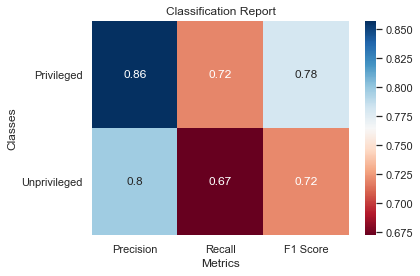

In [64]:
dir_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    dir_data, prob_priv_group, prob_unpriv_group, sensitive_attributes=['prob'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


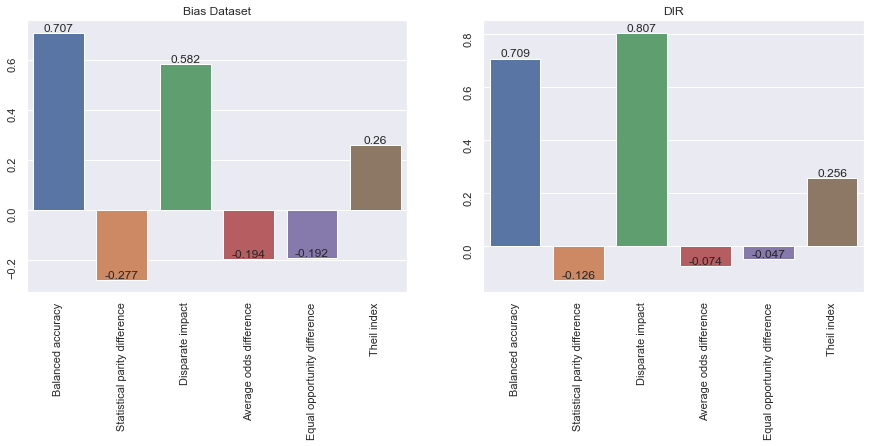

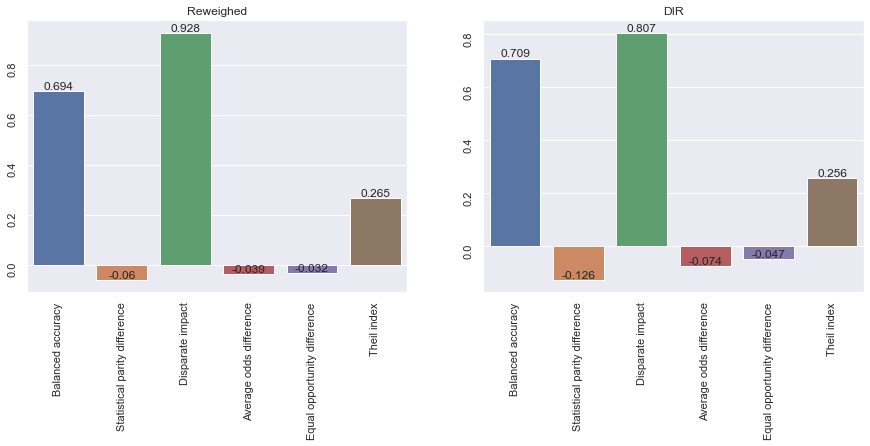

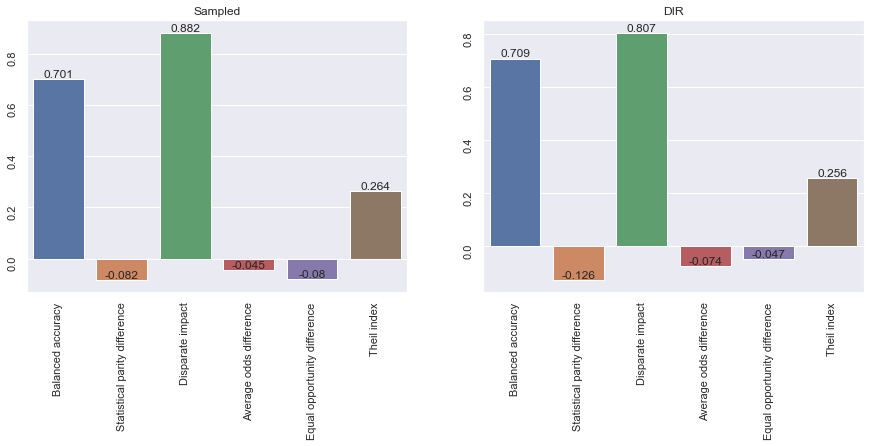

In [65]:
plot_metrics_comparison(bias_class, dir_class, 'Bias Dataset', 'DIR')
plot_metrics_comparison(rw_class, dir_class, 'Reweighed', 'DIR')
plot_metrics_comparison(sampled_class, dir_class, 'Sampled', 'DIR')
plt.show()

# Algorithms comparison

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


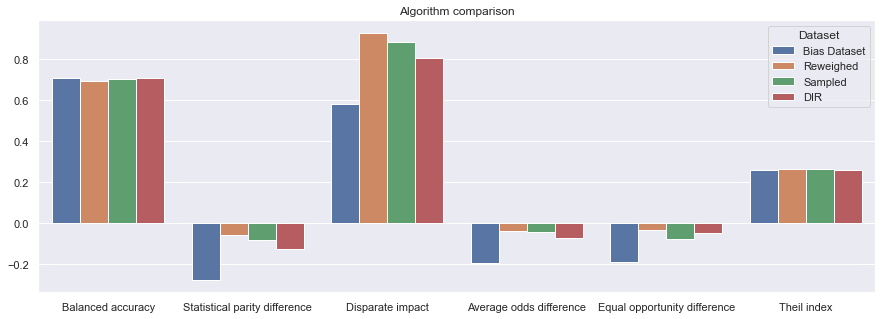

In [67]:
plot_syntesis(merge_datasets({
    'Bias Dataset': bias_class,
    'Reweighed': rw_class,
    'Sampled': sampled_class,
    'DIR': dir_class
}), 'Algorithm comparison')
plt.show()

# Case with single sensitive attribute

In [73]:
german = GermanDataset(protected_attribute_names=['age'], privileged_classes=[lambda x: x>25], features_to_drop=['sex', 'personal_status'])

In [79]:
german.labels[german.labels == 2] = 0
german.unfavorable_label = 0

In [80]:
privileged_attr = [{'age': 1}]
unpriv_attr = [{'age': 0}]

## Bias Dataset case

In [81]:
metrics = compute_dataset_fairness_metrics(german, unpriv_attr, privileged_attr)

Disparate Impact = 0.7948
Statistical Parity = -0.1494


Balanced accuracy: 0.7176
Statistical parity difference: -0.2558
Disparate impact: 0.6044
Average odds difference: -0.1941
Equal opportunity difference: -0.2172
Theil index: 0.2449


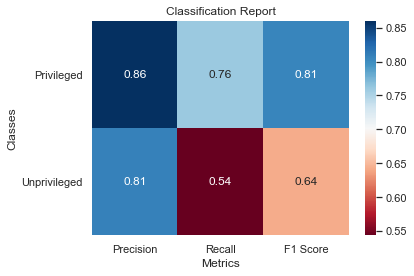

In [82]:
bias1_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    german, privileged_attr, unpriv_attr)

## Reweighing

In [83]:
rw1_data = german.copy()
rw = Reweighing(unpriv_attr, privileged_attr)
rw1_data = rw.fit_transform(rw1_data)

[0.7125     0.96101695 1.10454545 1.20909091]


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


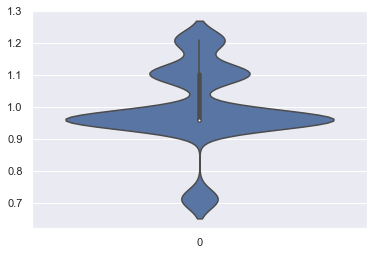

In [84]:
print(np.unique(rw1_data.instance_weights))
sns.violinplot(data=rw1_data.instance_weights)
plt.show()

In [85]:
metrics = compute_dataset_fairness_metrics(rw1_data, unpriv_attr, privileged_attr)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


Balanced accuracy: 0.7114
Statistical parity difference: -0.0521
Disparate impact: 0.9204
Average odds difference: -0.0162
Equal opportunity difference: -0.0772
Theil index: 0.2570


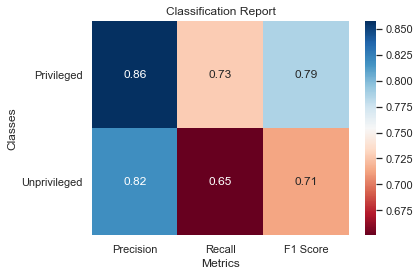

In [86]:
rw1_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    rw1_data, privileged_attr, unpriv_attr)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


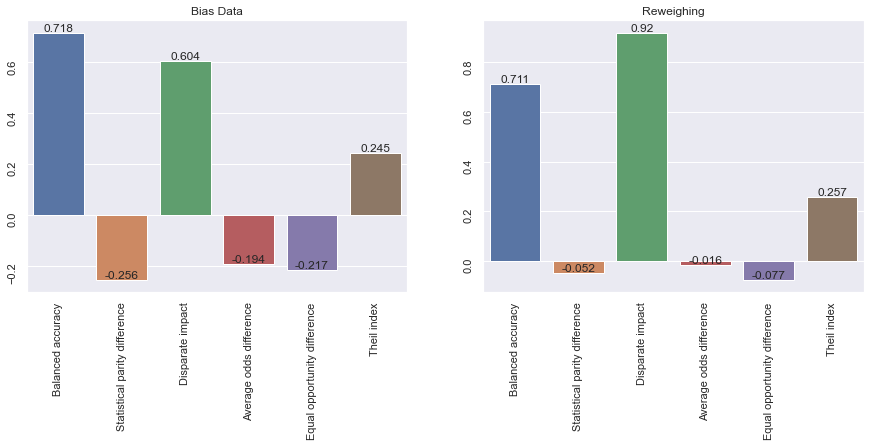

In [87]:
plot_metrics_comparison(bias1_class, rw1_class, 'Bias Data', 'Reweighing')
plt.show()

## Modified Reweighing (Sampling)

Original dataset size: (1000,58)
Sampled dataset size: (1000,58)


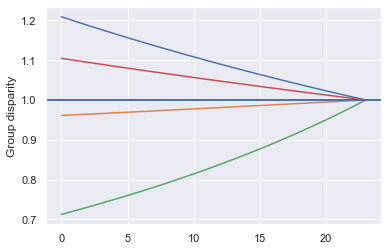

In [99]:
df = german.convert_to_dataframe()[0]
sampled1_data = sample_dataset(
    df,
    [df['age']==0, df['age']==1],
    df['credit']==1,
    df['credit']==0,
    ['age'], 'credit', round_level=15)

In [100]:
metrics = compute_dataset_fairness_metrics(sampled1_data, unpriv_attr, privileged_attr)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


Balanced accuracy: 0.7050
Statistical parity difference: 0.0067
Disparate impact: 1.0181
Average odds difference: 0.0402
Equal opportunity difference: -0.0369
Theil index: 0.2589


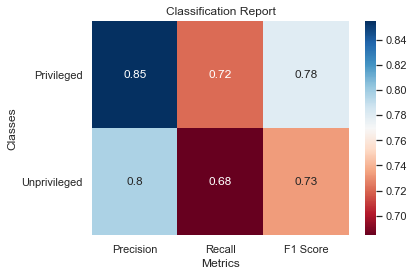

In [108]:
sampled1_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    sampled1_data, privileged_attr, unpriv_attr)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


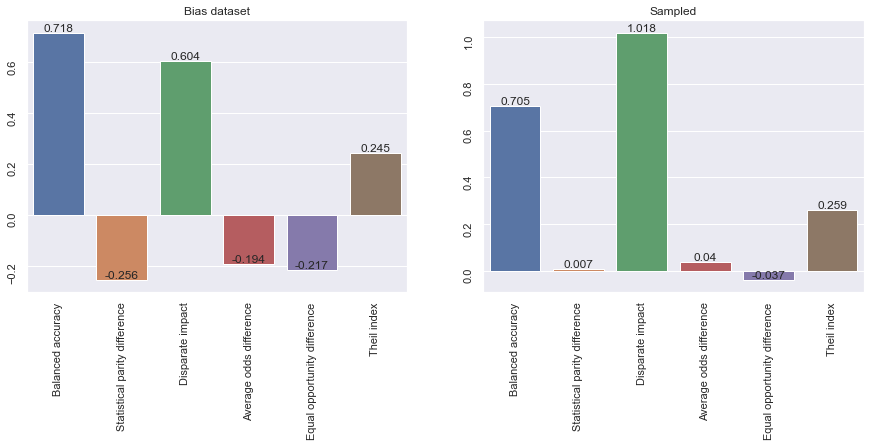

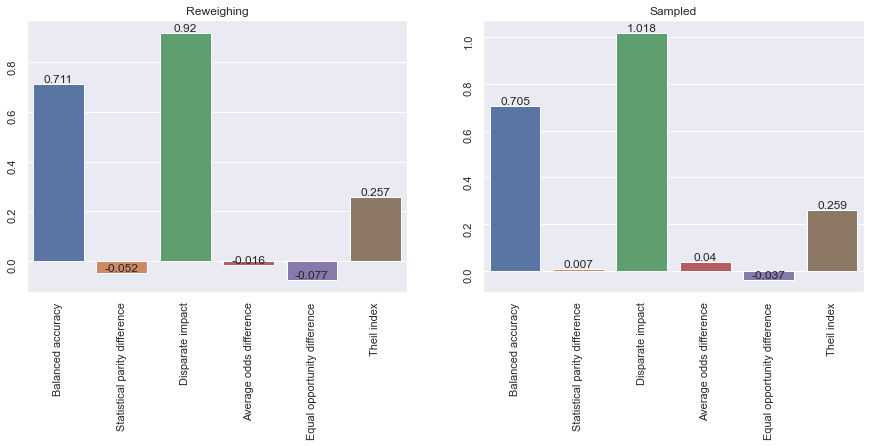

In [109]:
plot_metrics_comparison(bias1_class, sampled1_class, 'Bias dataset', 'Sampled')
plot_metrics_comparison(rw1_class, sampled1_class, 'Reweighing', 'Sampled')
plt.show()

## Disparate Impact Remover

In [111]:
scaler = MinMaxScaler(copy=False)
dir1_data = german.copy()
dir1_data.features = scaler.fit_transform(dir1_data.features)
di = DisparateImpactRemover(sensitive_attribute='age')
dir1_data = di.fit_transform(dir1_data)

In [112]:
metrics = compute_dataset_fairness_metrics(dir1_data, unpriv_attr, privileged_attr)

Disparate Impact = 0.7948
Statistical Parity = -0.1494


Balanced accuracy: 0.7167
Statistical parity difference: -0.1280
Disparate impact: 0.7980
Average odds difference: -0.0613
Equal opportunity difference: -0.0958
Theil index: 0.2472


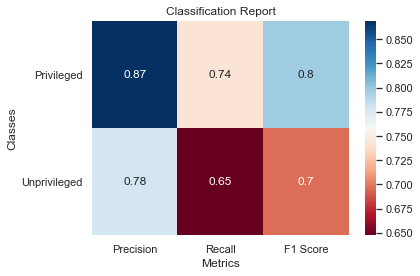

In [113]:
dir1_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    dir1_data, privileged_attr, unpriv_attr, sensitive_attributes=['age'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


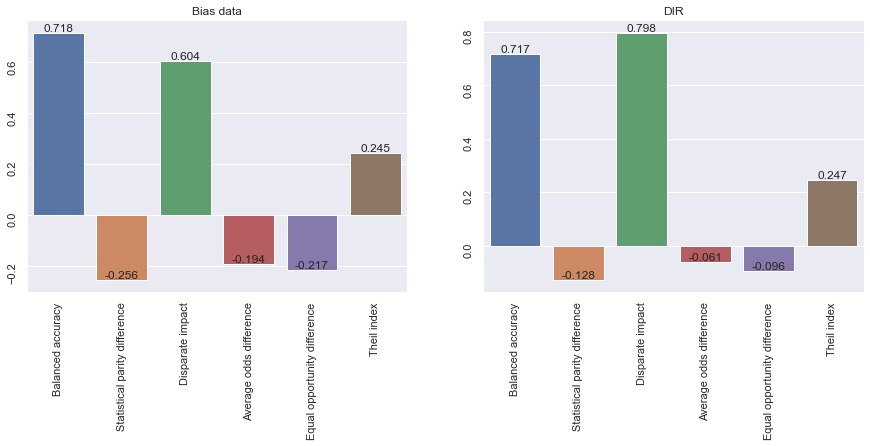

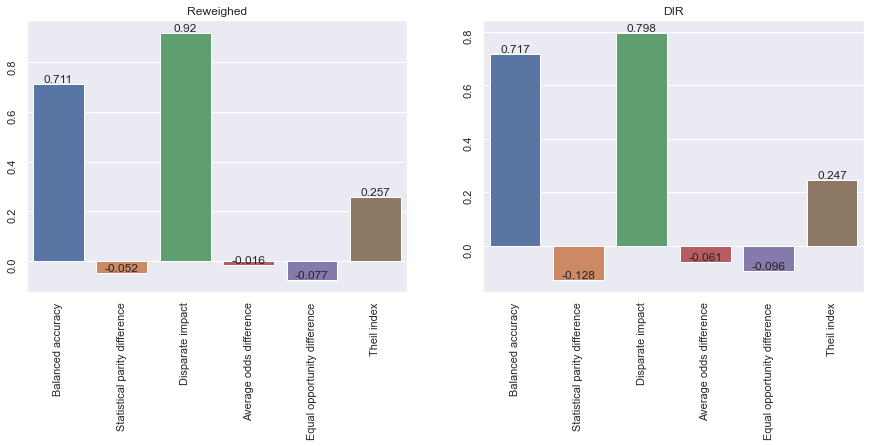

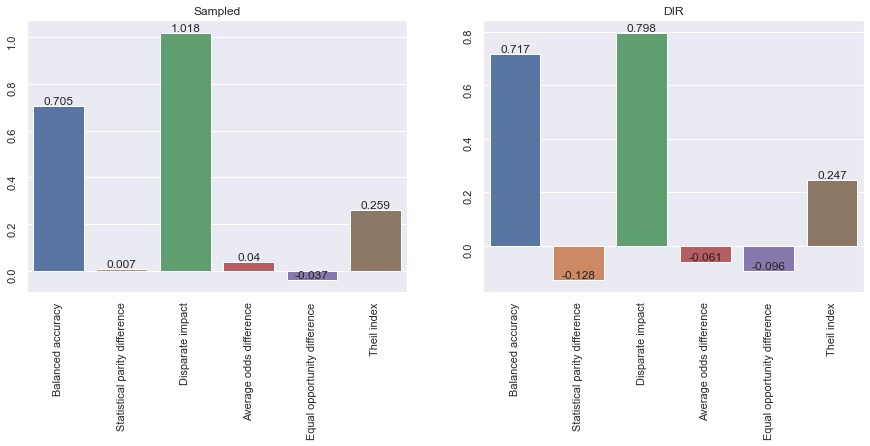

In [114]:
plot_metrics_comparison(bias1_class, dir1_class, 'Bias data', 'DIR')
plot_metrics_comparison(rw1_class, dir1_class, 'Reweighed', 'DIR')
plot_metrics_comparison(sampled1_class, dir1_class, 'Sampled', 'DIR')
plt.show()

## Algorithms comparison

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


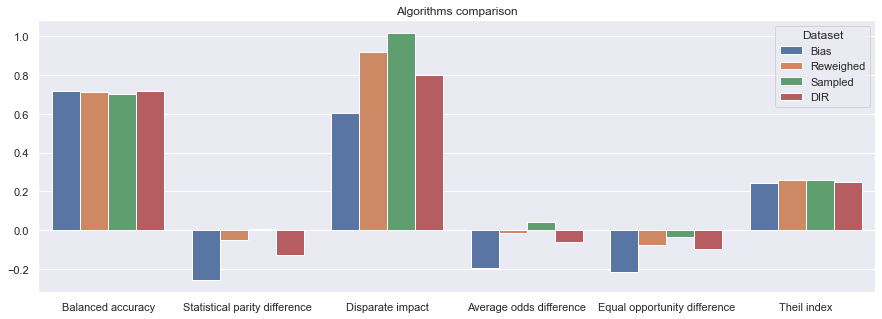

In [115]:
plot_syntesis(merge_datasets({
    'Bias': bias1_class,
    'Reweighed': rw1_class,
    'Sampled': sampled1_class,
    'DIR': dir1_class,
}), 'Algorithms comparison')
plt.show()